In [ ]:
import numpy as np

def xywh2xyxy(x_center, y_center, w_box, h_box, width, height):
    """
    Convert YOLO format (x_center, y_center, w_box, h_box) to (x1, y1, x2, y2)
    """
    x1 = int((x_center - w_box / 2) * width)
    y1 = int((y_center - h_box / 2) * height)
    x2 = int((x_center + w_box / 2) * width)
    y2 = int((y_center + h_box / 2) * height)

    # Clamp the coordinates to be within the image dimensions
    x1 = max(0, min(width - 1, x1))
    y1 = max(0, min(height - 1, y1))
    x2 = max(0, min(width - 1, x2))
    y2 = max(0, min(height - 1, y2))

    return x1, y1, x2, y2


def filter_occluded_boxes(label_file, img_height, img_width, occlusion_threshold=0.5):
    # Make annotations array
    with open(label_file, "r") as f:
        lines = f.readlines()

    num_lines = len(lines)
    annotations = np.zeros((num_lines, 5), dtype=np.float32)
    for i, line in enumerate(lines):
        # Split the line into components
        components = line.strip().split()
        # Extract the bounding box coordinates
        x_center, y_center, w_box, h_box, dist = map(float, components[1:6])

        # Convert to (x1, y1, x2, y2) format
        x1, y1, x2, y2 = xywh2xyxy(x_center, y_center, w_box, h_box, img_width, img_height)

        # Append the bounding box to the list
        annotations[i, 0] = x1
        annotations[i, 1] = y1
        annotations[i, 2] = x2
        annotations[i, 3] = y2
        annotations[i, 4] = dist


    # Sort the annotations by distance, largest to smallest
    annotations = annotations[np.argsort(annotations[:, 4])[::-1]]

    # Create a mock image with the same height and width as the image
    # and a channel for classification
    mock_image = np.zeros((img_height, img_width), dtype=np.int8)
    mock_image.fill(-1)

    total_area_per_annotation = np.zeros(num_lines, dtype=np.float32)
    visible_area_per_annotation = np.zeros(num_lines, dtype=np.float32)

    # Iterate over each annotation
    for i in range(num_lines):
        # Get the coordinates of the bounding box
        x1, y1, x2, y2 = annotations[i, :4].astype(int)

        # Calculate the area of the bounding box
        total_area = (x2 - x1) * (y2 - y1)
        total_area_per_annotation[i] = total_area

        # Add the mask to the mock image
        mock_image[y1:y2, x1:x2] = i

    for i in range(num_lines):
        # Compare the total area with the visible area
        visible_area = np.sum(mock_image == i)
        visible_area_per_annotation[i] = visible_area

    visibility_ratio_per_annotation = visible_area_per_annotation / total_area_per_annotation

    # Filter out annotations with ratio < 0.5
    valid_indices = np.where(visibility_ratio_per_annotation >= occlusion_threshold)[0]

    annotations = annotations[valid_indices]

    return annotations

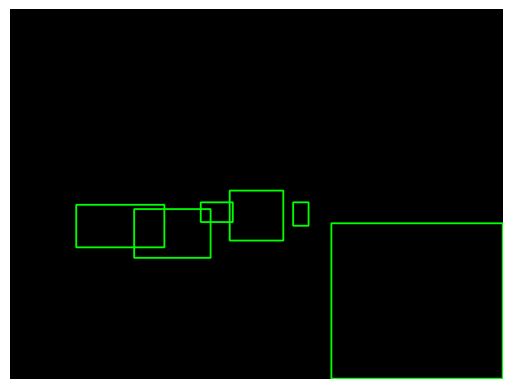

In [ ]:
# Visualize the bounding boxes on top of a blank image
import cv2
import numpy as np
import matplotlib.pyplot as plt

sample_label = "../../yolo-testing/datasets/carla-world06-day/labels/val/vid_86958-TOwn06-150npc_frame_000065.txt"
img_height, img_width = 600, 800  # Set the desired height and width
annotations = filter_occluded_boxes(sample_label, img_height, img_width, occlusion_threshold=0.5)

# Create a blank image
h, w = 600, 800  # Set the desired height and width
image = np.zeros((h,w, 3), dtype=np.uint8)
# Set the color for the bounding boxes (BGR format)
color = (0, 255, 0)  # Green
# Set the thickness of the bounding box lines
thickness = 2
# Draw the bounding boxes on the image
for i in range(annotations.shape[0]):
    bbox = annotations[i, :4]
    x1, y1, x2, y2 = map(int, bbox)
    # Draw the rectangle on the image
    cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
# Display the image with bounding boxes
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")  # Hide the axes
plt.show()
